## 1. 기본 세팅

In [47]:
import requests
import bs4

page_no = 1
kospi_page_url = f"https://finance.naver.com/sise/sise_index_day.naver?code=KOSPI&page={page_no}"

kospi_source = requests.get(kospi_page_url).text
kospi_source = bs4.BeautifulSoup(kospi_source)

kospi_last_url = kospi_source.find_all("td", class_="pgRR")[0].find_all("a")[0]["href"]

kospi_last_page = kospi_last_url.split('&page=')[-1]
kospi_last_page = int(kospi_last_page)

## 2. 페이지 돌면서 날짜, 가격 정보 리스트 만들기

In [48]:
date_list = []
price_list = []

# last_page까지의 모든 페이지를 순회합니다.
for page_no in range(1, kospi_last_page+1):

    # 페이지 번호에 따라 새로운 URL을 구성하고 소스를 가져와야 합니다.
    kospi_page_url = f"https://finance.naver.com/sise/sise_index_day.naver?code=KOSPI&page={page_no}"
    kospi_source = requests.get(kospi_page_url).text
    kospi_source = bs4.BeautifulSoup(kospi_source)

    # 'date' 클래스를 가진 'td' 태그에서 날짜 정보를 찾아 리스트에 추가합니다.
    dates = kospi_source.find_all("td", class_="date")
    for date in dates:
        date_list.append(date.text)
    
    # 'number_1' 클래스를 가진 'td' 태그에서 가격 정보를 찾습니다.
    # 여기서 주가 정보는 'number_1' 클래스의 첫 번째 요소이므로, 이를 추출합니다.
    prices = kospi_source.find_all("td", class_="number_1")
    for price in prices[::4]:
        price_list.append(price.text)


In [50]:
len(date_list)

8820

In [51]:
len(price_list)

8820

## 3. 날짜, 가격 리스트를 데이터프레임으로 만들기

In [52]:
import pandas as pd

df_kospi = pd.DataFrame({"date" : date_list,
                  "price" : price_list}).dropna()
    
# 날짜 데이터 형식 변환
df_kospi['date'] = pd.to_datetime(df_kospi['date'])

# 가격 데이터 형식 변환
df_kospi['price'] = df_kospi['price'].apply(lambda x: float(x.replace(",", "")))

df_kospi

,date,price
0,2024-01-12,2525.05
1,2024-01-11,2540.27
2,2024-01-10,2541.98
3,2024-01-09,2561.24
4,2024-01-08,2567.82
...,...,...
8815,1990-01-09,920.21
8816,1990-01-08,919.46
8817,1990-01-06,912.86
8818,1990-01-05,915.11


In [35]:
df_kospi.to_excel("210112_kospi.xlsx", index=False)

## S&P 500

In [57]:
!pip install selenium

     ---------------------------------------- 10.0/10.0 MB 2.6 MB/s eta 0:00:00
     ------------------------------------ 460.2/460.2 kB 600.0 kB/s eta 0:00:00
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl (24 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [98]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time


# Selenium 드라이버 설정
driver_path = '/chrome-win64'  # ChromeDriver의 경로
driver = webdriver.Chrome()
driver.get("https://finance.naver.com/world/sise.naver?symbol=NAS@IXIC")

data = []  # 데이터를 저장할 리스트

def scrape_page():
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CLASS_NAME, "tb_td"))
    )
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    dates = soup.find_all("td", class_="tb_td")
    closing_prices = soup.find_all("td", class_="tb_td2")
    for date, price in zip(dates, closing_prices):
        data.append({
            'date': date.get_text(),
            'price': price.get_text()
        })

current_page = 1
while True:
    scrape_page()
    if current_page % 10 == 0:  # 10 페이지마다 "다음" 버튼 확인
        try:
            next_page_link = driver.find_element(By.CLASS_NAME, 'next')
            next_page_link.click()
        except Exception as e:
            print("No more pages. Exiting.")
            break
    else:  # 일반 페이지 이동
        try:
            next_page_link = driver.find_element(By.ID, f'dayLink{current_page + 1}')
            next_page_link.click()
        except Exception as e:
            print("No more pages. Exiting.")
            break

    current_page += 1
    time.sleep(1)  # 서버에 부담을 주지 않기 위한 딜레이

driver.quit()

No more pages. Exiting.


In [87]:
import pandas as pd

df_snp = pd.DataFrame(data).dropna()
    
# 날짜 데이터 형식 변환
df_snp['date'] = pd.to_datetime(df_snp['date'])

# 가격 데이터 형식 변환
df_snp['price'] = df_snp['price'].apply(lambda x: float(x.replace(",", "")))

df_snp

,date,price
0,2024-01-11,4780.24
1,2024-01-10,4783.45
2,2024-01-09,4756.50
3,2024-01-08,4763.54
4,2024-01-05,4697.24
...,...,...
5543,2002-01-08,1160.71
5544,2002-01-07,1164.89
5545,2002-01-04,1172.51
5546,2002-01-03,1165.27


In [99]:
df_nas = pd.DataFrame(data).dropna()
    
# 날짜 데이터 형식 변환
df_nas['date'] = pd.to_datetime(df_nas['date'])

# 가격 데이터 형식 변환
df_nas['price'] = df_nas['price'].apply(lambda x: float(x.replace(",", "")))

df_nas

,date,price
0,2024-01-11,14970.19
1,2024-01-10,14969.65
2,2024-01-09,14857.71
3,2024-01-08,14843.77
4,2024-01-05,14524.07
...,...,...
5540,2002-01-08,2055.74
5541,2002-01-07,2037.10
5542,2002-01-04,2059.38
5543,2002-01-03,2044.27


## 4. 엑셀로 저장하기

In [97]:
df_snp.to_excel("210112_s&p500.xlsx", index=False)

In [100]:
df_nas.to_excel("210112_nasdaq.xlsx", index=False)

## 5. 그림그리기

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

# 설치된 폰트 목록에서 한글 폰트 경로 찾기
font_path = None
for font in fm.fontManager.ttflist:
    if 'NanumGothic' in font.name:  # 예: 'NanumGothic'
        font_path = font.fname
        break

# 한글 폰트 설정
if font_path:
    plt.rcParams['font.family'] = font.name
else:
    print("한글 폰트를 찾을 수 없습니다.")


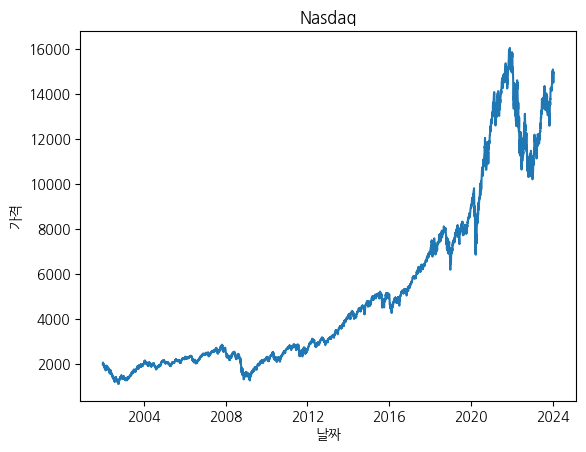

In [116]:
# 특정 기간 필터링
# start_date = '2011-01-02'
# end_date = '2024-01-11'

# mask = (df_nas['date'] >= start_date) & (df_nas['date'] <= end_date)
# df_nas1 = df_nas.loc[mask]

# 필터링된 데이터로 선 그래프 그리기
plt.plot(df_nas['date'], df_nas['price'])
plt.title('Nasdaq')
plt.xlabel('날짜')
#plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # 최대 5개의 레이블만 표시
plt.ylabel('가격')
plt.show()